In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install corner
!pip install lenstronomy

# Change directory to where the gigalens directory is at
%cd /content/drive/"My Drive"/gigalens

Mounted at /content/drive
     |████████████████████████████████| 3.3 MB 12.2 MB/s 
  Created wheel for lenstronomy: filename=lenstronomy-1.9.1-py3-none-any.whl size=729171 sha256=0f05be5aa7ba085ae6c60445594789a0d79b09b6aac9d9a97399b7161380a494
  Stored in directory: /root/.cache/pip/wheels/28/8d/f3/6cd8ab812d974deadf466772b750b79e5b549f14a005ffc622
Successfully built lenstronomy
/content/drive/My Drive/gigalens


In [2]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import epl, shear

sns.set_style("whitegrid")
tfd = tfp.distributions

In [3]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(tf.math.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(tf.math.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(tf.math.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(tf.math.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(tf.math.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

In [4]:
prior.sample(2)

[[{'center_x': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.0486581 , 0.03750799], dtype=float32)>,
   'center_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.0637944 , -0.00985012], dtype=float32)>,
   'e1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.02785378, 0.07668123], dtype=float32)>,
   'e2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.03730809, -0.02801536], dtype=float32)>,
   'gamma': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.9114738, 1.7764804], dtype=float32)>,
   'theta_E': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.0152562, 1.061618 ], dtype=float32)>},
  {'gamma1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.02670549, 0.03752014], dtype=float32)>,
   'gamma2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.08589592, -0.02582704], dtype=float32)>}],
 [{'Ie': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([367.8765 , 324.24222], dtype=float32)>,
   'R_sersic': <tf.Tensor: shape=(2,), dty

Load the data. The ground truth parameters are in `truth`. Various hyperparameters, including the noise scale and exposure time are fixed.

The PSF is generated from `TinyTim` for HST F140W band, and has been supersampled to the pixel scale of 0.065.

In [5]:
truth = [[
    {'theta_E': 1.1, 'gamma': 2.0, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.0},
    {'gamma1': -0.01, 'gamma2': 0.03}
], [
    {'R_sersic': 0.8, 'n_sersic': 2.5, 'e1': 0.09534746574143645, 'e2': 0.14849487967198177, 'center_x': 0.1, 'center_y': 0.0, 'Ie': 499.3695906504067}
], [
    {'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': 0.09566681002252231, 'center_y': -0.0639623054267272, 'Ie': 149.58828877085668}
]]

In [6]:
kernel = np.load('./assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = np.load('./assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.2, exp_time=100)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

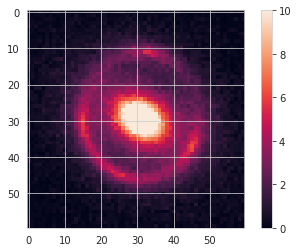

In [7]:
plt.imshow(observed_img, vmin=0, vmax=10)
plt.colorbar()

Sanity check: calculate residuals using ground truth.

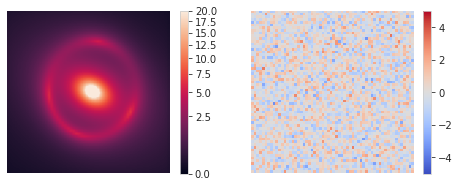

In [8]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
plt.colorbar()
plt.axis('off')
plt.subplot(122)
simulated = lens_sim.simulate(truth)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
plt.axis('off')
plt.colorbar()

Begin fitting. We use `supersample=1` for this demonstration to speed things up, but setting `supersample=2` is recommended in practice. This will not significantly slow down the fitting.

In [9]:
fitter = ModellingSequence(phys_model, prob_model, sim_config)

In [10]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, 300, 1e-2/5)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=500, num_steps=300, seed=0)

  0%|          | 0/300 [00:00<?, ?it/s]

In [11]:
lens_sim_500 = LensSimulator(phys_model, sim_config, bs=500)
lps = prob_model.log_prob(lens_sim_500, MAP)[0]
best = MAP[tf.argmax(lps).numpy()]

In [12]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=500, num_steps=1000)

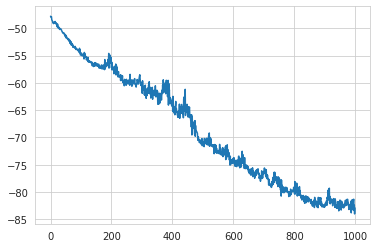

In [13]:
plt.plot(losses)

In [14]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

In [15]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
ESS = tfp.mcmc.effective_sample_size(samples, cross_chain_dims=1).numpy()
print(Rhat, ESS)

[1.0019618 1.0033723 1.0077738 1.0091486 1.0267249 1.0099442 1.0248796
 1.0161691 1.0004616 1.0004218 1.0009754 1.0018462 1.0007452 1.0007095
 1.0008813 1.0031664 1.0196155 1.0006118 1.0228744 1.0069796 1.0015277
 1.0031555] [18032.588  12141.003   7029.018   5711.2     2245.199   5114.5464
  2341.885   3511.311  26506.055  25866.904  23867.623  24519.758
 30351.936  28870.422  26768.258   9994.665   3123.627  27626.787
  2539.0933 27317.385  29867.045  10336.956 ]


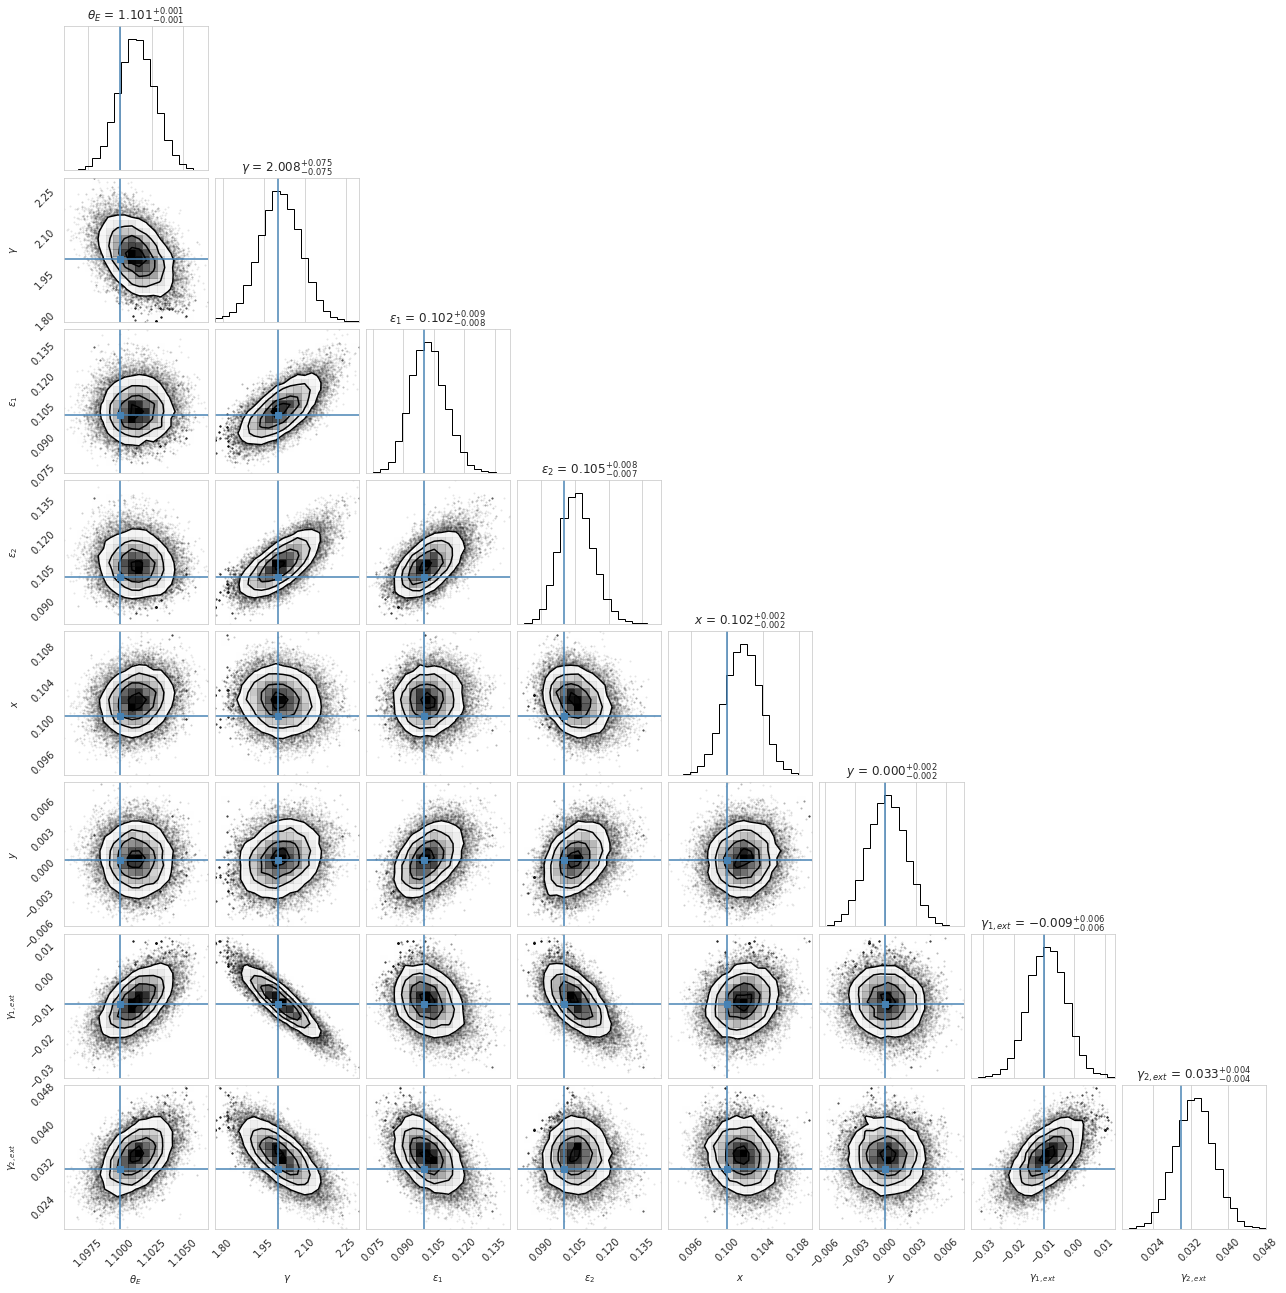

In [16]:
get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['theta_E'],
    x[0][0]['gamma'],
    x[0][0]['e1'],
    x[0][0]['e2'],
    x[0][0]['center_x'],
    x[0][0]['center_y'],
    x[0][1]['gamma1'],
    x[0][1]['gamma2'],
])
physical_samples = get_samples(prob_model.bij.forward(samples)).numpy()
markers = get_samples(truth)
corner(physical_samples.reshape((8,-1)).T, truths=markers, 
       show_titles=True, title_fmt='.3f',
       labels=[r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x$', r'$y$', r'$\gamma_{1,ext}$', r'$\gamma_{2,ext}$']);